# MaxEnt Large — Three Interlinked Variables

This notebook demonstrates the HMC-based `maxent_large` solver on a problem with **three interlinked continuous variables** and plots the resulting marginal distributions.

**Scenario**: We model three economic indicators — *GDP Growth*, *Unemployment Rate*, and *Inflation Rate* — linked by conditional probability and conditional expectation estimates that encode stylised macroeconomic relationships:

| Estimate | Meaning |
|----------|---------|
| E[GDP] = 2.5% | Average GDP growth |
| P(Unemployment > 6%) = 0.35 | Moderate chance of high unemployment |
| E[Inflation] = 3.0% | Average inflation |
| P(GDP > 3% \| Unemployment < 5%) = 0.7 | Strong GDP when unemployment is low |
| E[Inflation \| GDP > 3%] = 3.5% | Higher inflation when GDP is strong |
| P(Unemployment > 7% \| GDP < 1.5%) = 0.6 | Weak GDP raises unemployment risk |

In [28]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from calibrated_response.maxent_large.distribution_builder import DistributionBuilder
from calibrated_response.maxent_large.maxent_solver import JAXSolverConfig

from calibrated_response.models.variable import ContinuousVariable
from calibrated_response.models.query import (
    ProbabilityEstimate,
    ExpectationEstimate,
    ConditionalProbabilityEstimate,
    ConditionalExpectationEstimate,
    InequalityProposition,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1) Define Variables & Estimates

In [29]:
# --- Variables ---
variables = [
    ContinuousVariable(name="gdp_growth",    description="Annual GDP growth rate (%)", lower_bound=-2.0, upper_bound=8.0, unit="%"),
    ContinuousVariable(name="unemployment",  description="Unemployment rate (%)",      lower_bound=2.0,  upper_bound=12.0, unit="%"),
    ContinuousVariable(name="inflation",     description="Inflation rate (%)",         lower_bound=0.0,  upper_bound=8.0,  unit="%"),
]

# --- Estimates (marginal + conditional cross-links) ---
estimates = [
    # Marginal: E[GDP growth] = 2.5%
    ExpectationEstimate(id="e_gdp", variable="gdp_growth", expected_value=2.5),

    # Marginal: P(Unemployment > 6%) = 0.35
    ProbabilityEstimate(
        id="p_unemp_high",
        proposition=InequalityProposition(variable="unemployment", variable_type="continuous", threshold=6.0, is_lower_bound=True),
        probability=0.35,
    ),

    # Marginal: E[Inflation] = 3.0%
    ExpectationEstimate(id="e_infl", variable="inflation", expected_value=3.0),

    # Cross-link 1: P(GDP > 3% | Unemployment < 5%) = 0.70
    ConditionalProbabilityEstimate(
        id="cp_gdp_given_low_unemp",
        proposition=InequalityProposition(variable="gdp_growth", variable_type="continuous", threshold=3.0, is_lower_bound=True),
        conditions=[InequalityProposition(variable="unemployment", variable_type="continuous", threshold=5.0, is_lower_bound=False)],
        probability=0.70,
    ),

    # Cross-link 2: E[Inflation | GDP > 3%] = 3.5%
    ConditionalExpectationEstimate(
        id="ce_infl_given_high_gdp",
        variable="inflation",
        conditions=[InequalityProposition(variable="gdp_growth", variable_type="continuous", threshold=3.0, is_lower_bound=True)],
        expected_value=3.5,
    ),

    # Cross-link 3: P(Unemployment > 7% | GDP < 1.5%) = 0.60
    ConditionalProbabilityEstimate(
        id="cp_unemp_given_low_gdp",
        proposition=InequalityProposition(variable="unemployment", variable_type="continuous", threshold=7.0, is_lower_bound=True),
        conditions=[InequalityProposition(variable="gdp_growth", variable_type="continuous", threshold=1.5, is_lower_bound=False)],
        probability=0.60,
    ),
]

print(f"{len(variables)} variables, {len(estimates)} estimates")

3 variables, 6 estimates


## 2) Build the MaxEnt Distribution

In [30]:
config = JAXSolverConfig(
    num_chains=256,
    num_iterations=200,
    mcmc_steps_per_iteration=4,
    learning_rate=0.0015,

    l2_regularization=1e-2,

    hmc_step_size=0.015,
    hmc_leapfrog_steps=10,
    max_bins=15,
    seed=42,
    verbose=True,
)

builder = DistributionBuilder(variables=variables, estimates=estimates, solver_config=config)

# Build for GDP growth (the solver trains once; marginals for all variables are in info)
distribution, info = builder.build(target_variable="gdp_growth")

print(f"\nConverged: {info['converged']}")
print(f"Features used: {info['n_features']}")
print(f"Skipped: {info['skipped_constraints']}")

[MaxEntSolver] iter   50  max_err=0.181286  mean_err=0.102810  accept=0.988  step_size=0.17201
[MaxEntSolver] iter  100  max_err=0.189370  mean_err=0.096092  accept=0.741  step_size=0.50000
[MaxEntSolver] iter  150  max_err=0.200603  mean_err=0.097389  accept=0.655  step_size=0.49378
[MaxEntSolver] iter  200  max_err=0.144171  mean_err=0.087859  accept=0.637  step_size=0.37969

Converged: False
Features used: 9
Skipped: []


In [ ]:
model = info['energy_model']
import jax
samples = model.sample_original(n_samples=int(1e4))
#use seaborn to plot the joint marginal distribution of GDP growth and inflation from samples
import seaborn as sns
sns.set_style("whitegrid")
sns.kdeplot(x=samples[:, 0], y=samples[:, 2], fill=True, thresh=0.01, cmap="viridis")
plt.xlabel("GDP Growth (%)")
plt.ylabel("Inflation Rate (%)")
plt.title("Joint Distribution of GDP Growth and Inflation")

Text(0.5, 1.0, 'Joint Distribution of GDP Growth and Inflation')

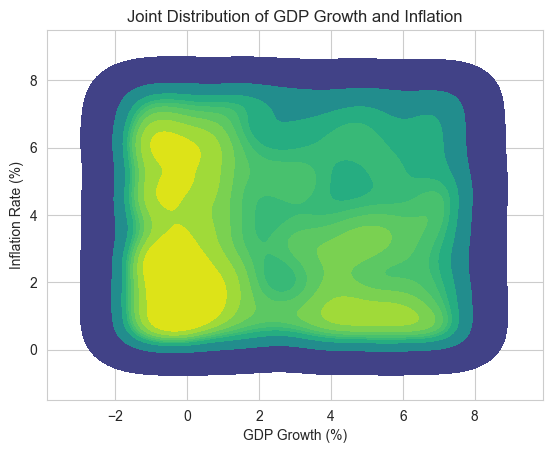

In [43]:
#use seaborn to plot the joint marginal distribution of GDP growth and inflation from samples
import seaborn as sns
sns.set_style("whitegrid")
sns.kdeplot(x=samples[:, 0], y=samples[:, 2], fill=True, thresh=0.01, cmap="viridis")
plt.xlabel("GDP Growth (%)")
plt.ylabel("Inflation Rate (%)")
plt.title("Joint Distribution of GDP Growth and Inflation")

## 3) Training Diagnostics

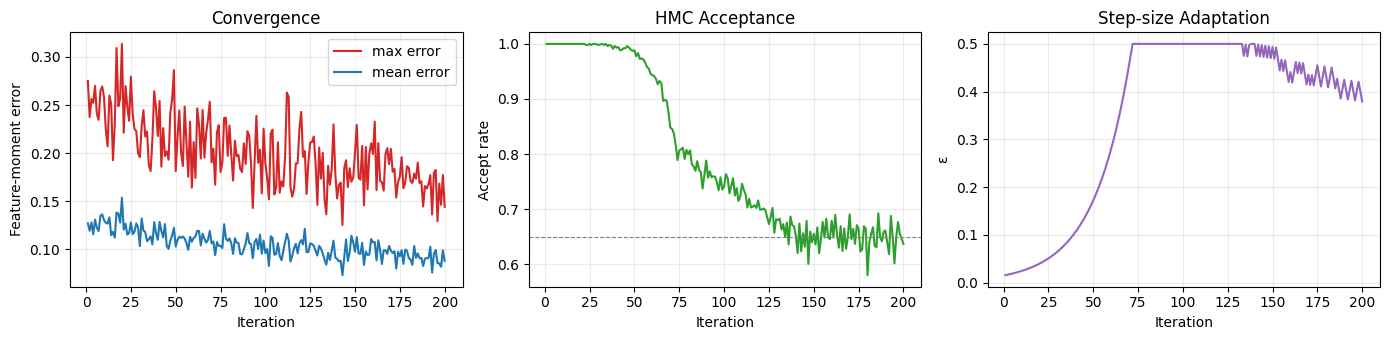

Final max error:  0.14417
Final mean error: 0.08786
Final accept rate: 0.637


In [26]:
history = info["history"]

fig, axes = plt.subplots(1, 3, figsize=(14, 3.5))

axes[0].plot(history["iteration"], history["max_error"], label="max error", color="C3")
axes[0].plot(history["iteration"], history["mean_error"], label="mean error", color="C0")
axes[0].set_xlabel("Iteration"); axes[0].set_ylabel("Feature-moment error")
axes[0].set_title("Convergence"); axes[0].legend(); axes[0].grid(alpha=0.25)

axes[1].plot(history["iteration"], history["accept_rate"], color="C2")
axes[1].axhline(config.target_accept_rate, ls="--", color="gray", lw=0.8)
axes[1].set_xlabel("Iteration"); axes[1].set_ylabel("Accept rate")
axes[1].set_title("HMC Acceptance"); axes[1].grid(alpha=0.25)

axes[2].plot(history["iteration"], history["step_size"], color="C4")
axes[2].set_xlabel("Iteration"); axes[2].set_ylabel("ε")
axes[2].set_title("Step-size Adaptation"); axes[2].grid(alpha=0.25)

plt.tight_layout(); plt.show()

print(f"Final max error:  {history['max_error'][-1]:.5f}")
print(f"Final mean error: {history['mean_error'][-1]:.5f}")
print(f"Final accept rate: {history['accept_rate'][-1]:.3f}")

In [ ]:
import jax

energy_fn = builder.solver._energy_fn
batch_energy_fn = jax.vmap(energy_fn, in_axes=(0, None))

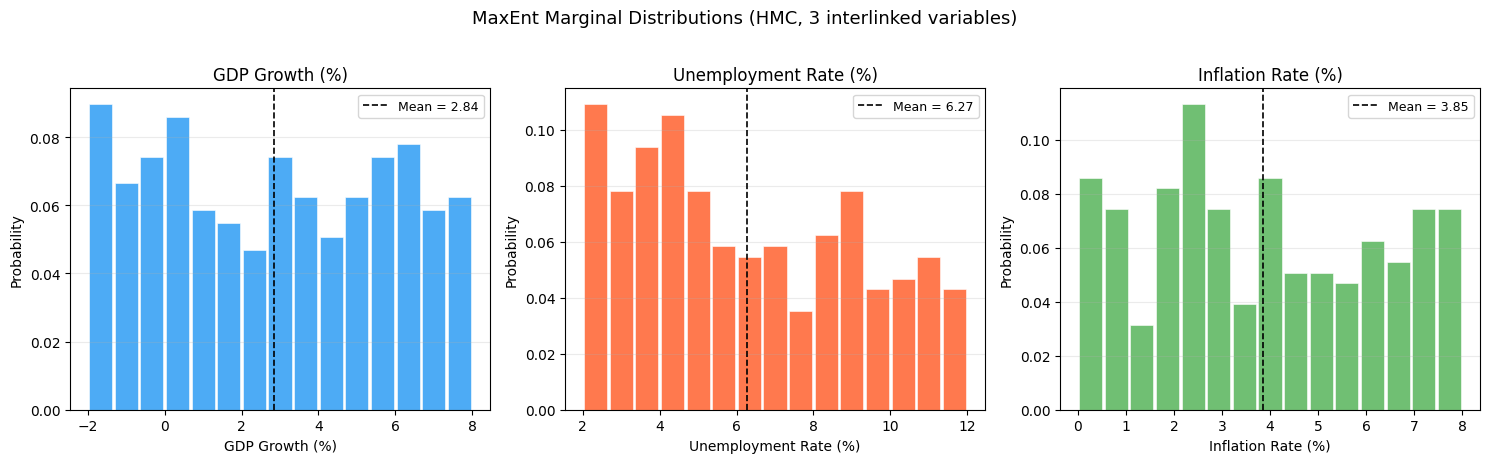

           GDP Growth (%):  mean = 2.84,  std = 2.97
    Unemployment Rate (%):  mean = 6.27,  std = 2.90
       Inflation Rate (%):  mean = 3.85,  std = 2.36


In [27]:
all_marginals = builder.get_all_marginals(info)

colors = {"gdp_growth": "#2196F3", "unemployment": "#FF5722", "inflation": "#4CAF50"}
labels = {"gdp_growth": "GDP Growth (%)", "unemployment": "Unemployment Rate (%)", "inflation": "Inflation Rate (%)"}

fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

for ax, (name, dist) in zip(axes, all_marginals.items()):
    edges = np.array(dist.bin_edges)
    centers = (edges[:-1] + edges[1:]) / 2.0
    widths = edges[1:] - edges[:-1]
    probs = np.array(dist.bin_probabilities)

    ax.bar(centers, probs, width=widths * 0.9, color=colors[name], alpha=0.8, edgecolor="white", linewidth=0.5)

    # Mark the mean
    mean = float(np.dot(centers, probs))
    ax.axvline(mean, color="black", ls="--", lw=1.2, label=f"Mean = {mean:.2f}")

    ax.set_xlabel(labels[name])
    ax.set_ylabel("Probability")
    ax.set_title(labels[name])
    ax.legend(fontsize=9)
    ax.grid(axis="y", alpha=0.25)

plt.suptitle("MaxEnt Marginal Distributions (HMC, 3 interlinked variables)", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

# Print summary statistics
for name, dist in all_marginals.items():
    edges = np.array(dist.bin_edges)
    centers = (edges[:-1] + edges[1:]) / 2.0
    probs = np.array(dist.bin_probabilities)
    mean = float(np.dot(centers, probs))
    std = float(np.sqrt(np.dot(probs, (centers - mean) ** 2)))
    print(f"{labels[name]:>25s}:  mean = {mean:.2f},  std = {std:.2f}")

## 5) Pairwise Joint Scatter Plots

Visualize the cross-variable structure encoded by the conditional estimates by plotting samples from the persistent HMC chains.

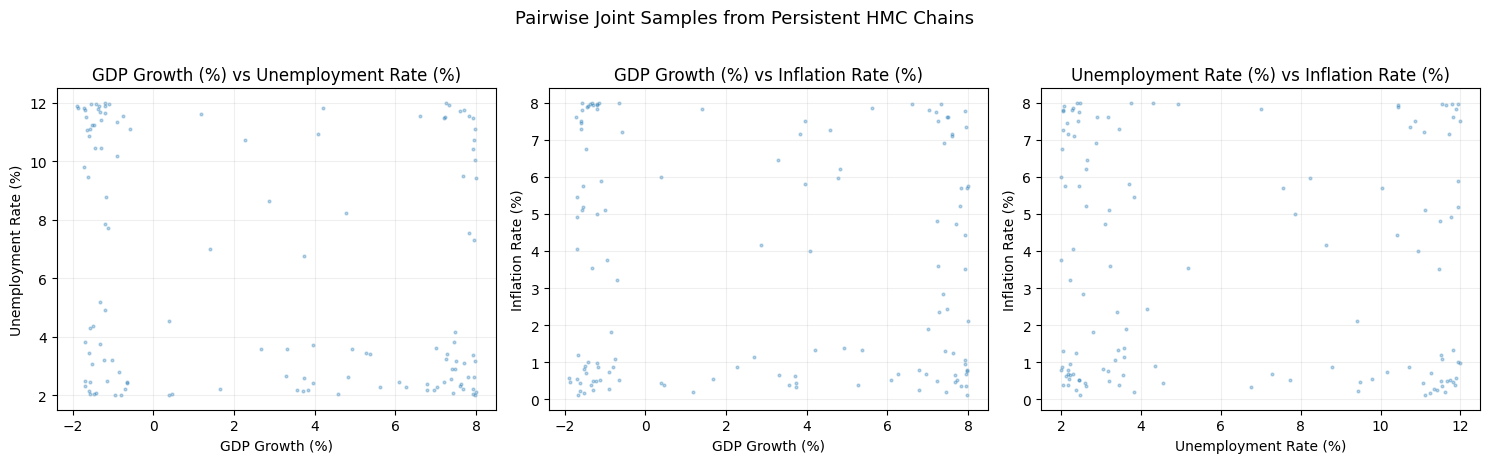

In [7]:
# --- Pairwise scatter plots from MCMC chains (original domain) ---
chain_states = info["chain_states"]  # (C, 3) in normalised [0,1]

# Denormalize back to original domains for plotting
from calibrated_response.maxent_large.normalizer import ContinuousDomainNormalizer
normalizer = ContinuousDomainNormalizer(variables)
chains_orig = np.zeros_like(chain_states)
for i, var in enumerate(variables):
    chains_orig[:, i] = np.array([normalizer.denormalize_value(var.name, float(v)) for v in chain_states[:, i]])

var_labels = [labels[v.name] for v in variables]
pairs = [(0, 1), (0, 2), (1, 2)]

fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))
for ax, (i, j) in zip(axes, pairs):
    ax.scatter(chains_orig[:, i], chains_orig[:, j], s=4, alpha=0.3, color="C0")
    ax.set_xlabel(var_labels[i])
    ax.set_ylabel(var_labels[j])
    ax.set_title(f"{var_labels[i]} vs {var_labels[j]}")
    ax.grid(alpha=0.2)

plt.suptitle("Pairwise Joint Samples from Persistent HMC Chains", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()